In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_nodeinfo.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_nodeinfotest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 1].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 1].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.543895,0.008625,924.236712,63156.175327,0.176144,2128.447148,10523.371640,1.0,50.0,0.103940,6.0,44.260521,1.240458e+10,36.548910
1,0.555150,0.011289,12651.807738,94205.906535,0.176144,6182.507055,20512.544166,1.0,192.0,0.108720,6.0,44.260521,1.240458e+10,37.249118
2,0.521781,0.010222,12652.088889,107315.200000,0.196314,7243.755556,20228.244444,1.0,333.0,0.105527,6.0,15.116667,1.240458e+10,37.249118
3,0.521781,0.009778,11832.888889,115234.133333,0.196314,8994.822222,25560.088889,1.0,474.0,0.108370,6.0,15.116667,1.240458e+10,37.201915
4,0.406110,0.008533,0.000000,97939.911111,0.196123,7063.244444,18804.822222,1.0,564.0,0.103987,6.0,10.733333,1.240458e+10,37.201915


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_t['networkTransmitted'] = df['networkTransmitted']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_ttest['networkTransmitted'] = df_test['networkTransmitted']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests,networkTransmitted
0,1.779273,453.373747,0.103940,50.0,10523.371640
1,1.779273,462.059520,0.108720,192.0,20512.544166
2,0.607690,462.059520,0.105527,333.0,20228.244444
3,0.607690,461.473997,0.108370,474.0,25560.088889
4,0.431480,461.473997,0.103987,564.0,18804.822222


In [6]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests,networkTransmitted
3238,2.466929,718.359552,0.990629,25003.0,33061.484429
3239,2.331137,717.664051,0.990629,31763.0,20271.428254
3240,2.331137,717.664051,0.990629,31739.0,7231.211946
3242,2.255263,718.881792,0.990629,14074.0,22449.902248
3243,2.401916,719.922586,0.990629,6981.0,28183.310017


In [7]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [8]:
df_t.shape

(2653, 5)

In [9]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

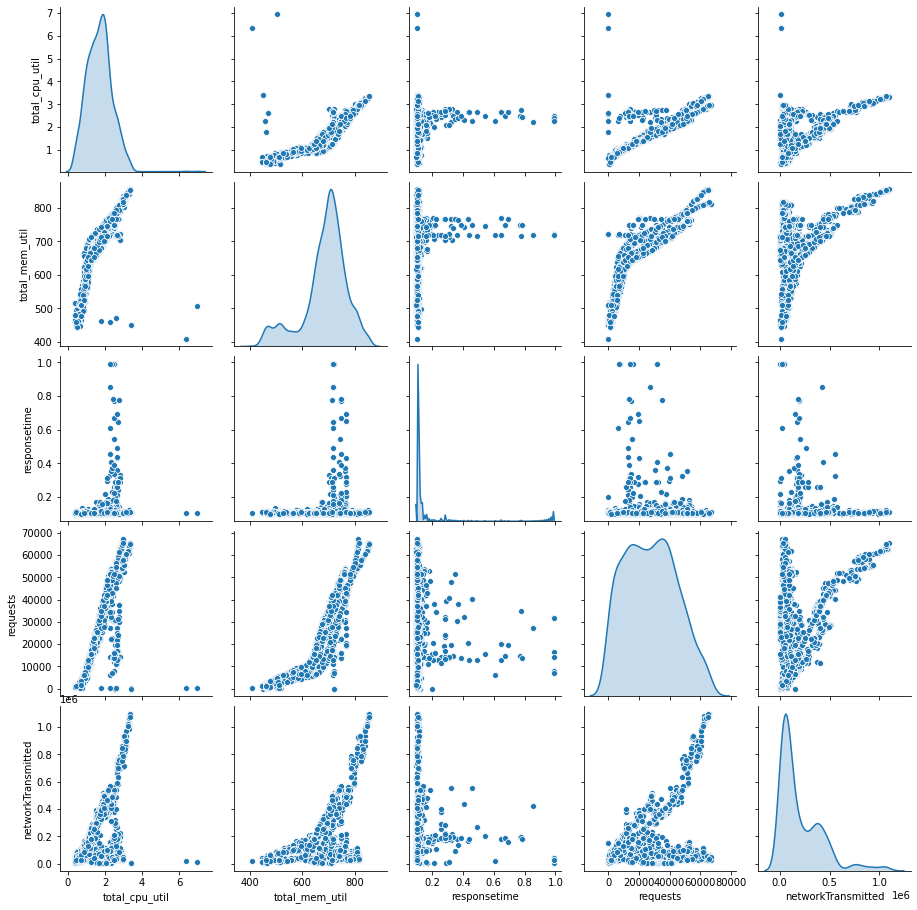

In [10]:
#sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests', 'networkTransmitted']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,2122.0,1.711742,0.658658,0.377210,1.232821,1.715312,2.116083,6.944027e+00
total_mem_util,2122.0,688.528166,82.999893,408.856781,656.844595,702.963917,738.165197,8.547410e+02
responsetime,2122.0,0.117511,0.071368,0.098689,0.103033,0.105875,0.109728,9.906293e-01
requests,2122.0,27997.709237,16787.863228,1.000000,14090.500000,27505.000000,40585.000000,6.729300e+04
networkTransmitted,2122.0,206499.376679,214944.918816,882.561307,52679.166667,111630.577778,342369.766667,1.098030e+06


In [12]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [13]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests,networkTransmitted
1769,2.482127,777.788634,0.103028,46932.0,474342.466667
2759,2.094197,743.110042,0.134667,47191.0,81392.955556
2848,2.565653,766.167859,0.156649,19952.0,155613.324741
1676,2.027502,734.698915,0.109914,34147.0,368554.333333
3063,1.602094,672.946790,0.141650,26715.0,4471.035264


In [14]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [15]:
# input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime', 'networkTransmitted']])
input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max(history.history['loss']+history.history['val_loss'])+100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [requests]')
  plt.legend()
  plt.grid(True)
  return plt.show()

In [17]:
def plot_prediction(test_labels, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values requests')
    plt.ylabel('Predictions requests')
    lims = [0, max(list(test_labels)+list(test_predictions))+100]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    return plt.show()

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_one (Dense)            (None, 64)                320       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


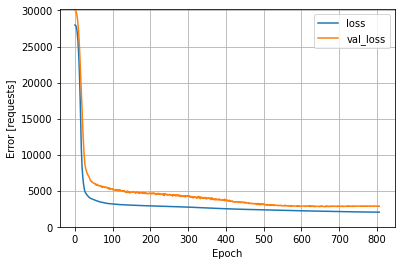

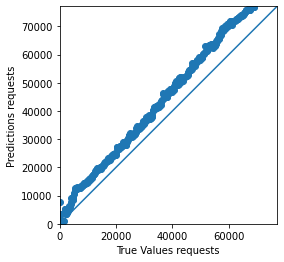

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_one (Dense)            (None, 64)                320       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


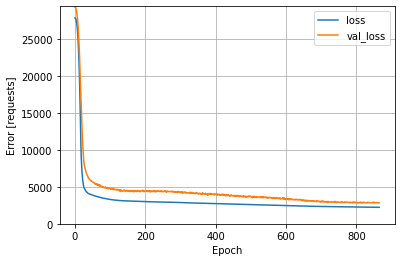

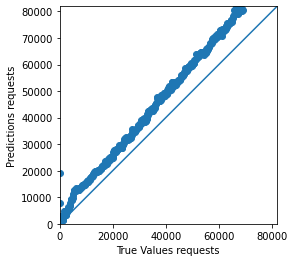

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_one (Dense)            (None, 64)                320       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


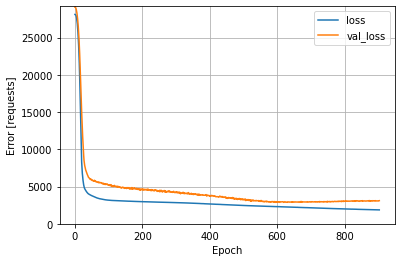

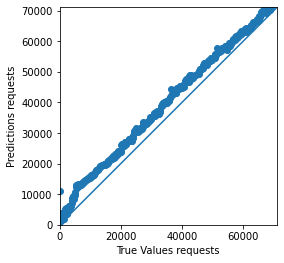

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_one (Dense)            (None, 64)                320       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


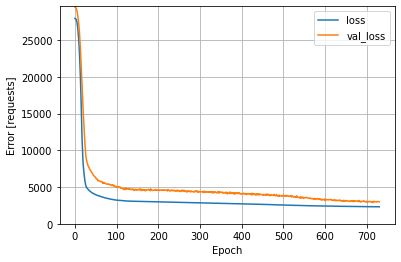

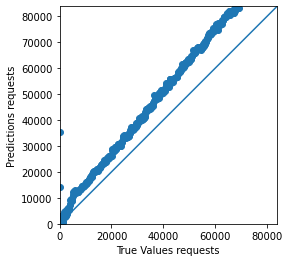

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_one (Dense)            (None, 64)                320       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


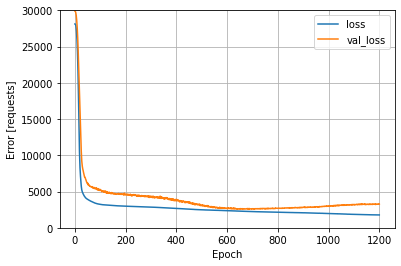

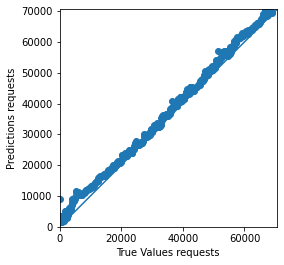

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_one (Dense)            (None, 64)                320       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


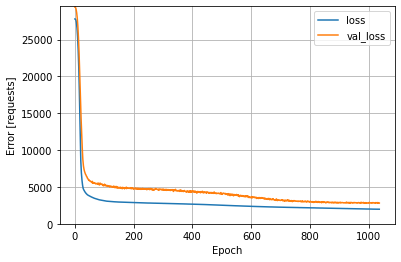

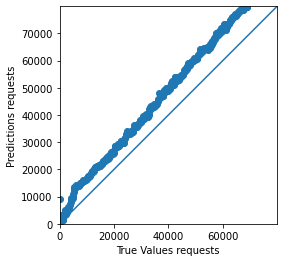

In [19]:
#%%time
i = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime', 'networkTransmitted']].values
#X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values
kf = KFold(n_splits=6, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    #input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer = preprocessing.Normalization(input_shape=[4,])
    input_normalizer.adapt(input)

# Create Model
    dnn_model = None
    dnn_model = build_and_compile_model(input_normalizer)

    print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    plot_loss(history)
    loss.append(dnn_model.evaluate(val_features, val_labels,verbose=0))
    ## Make Predictions
    test_predictions = dnn_model.predict(test_features).flatten()

    plot_prediction(test_labels, test_predictions)
    R = r2_score(test_labels, test_predictions)*100
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

In [20]:
data = np.array([model, loss, score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

,model,loss,score
0,dnn_model_0,2216.16650390625,86.2224666259933
1,dnn_model_1,2657.1640625,81.18335717120661
2,dnn_model_2,2059.61767578125,94.48221512045146
3,dnn_model_3,2398.743896484375,70.37111985857628
4,dnn_model_4,2023.3623046875,98.59543190052746
5,dnn_model_5,2482.10205078125,79.44300578340844


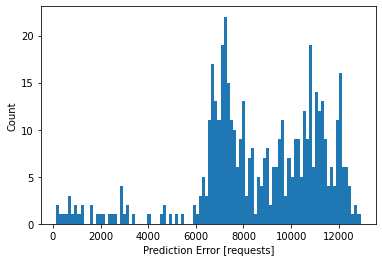

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')